# Visualize Model Coefficients

**Gregory Way, 2019**

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggrepel))

In [2]:
process_coefficients <- function(coef_file) {
    coef_df <- readr::read_tsv(coef_file,
                               col_types=readr::cols(
                                   .default = readr::col_double(),
                                   features = readr::col_character())
                              )
    
    coef_sums_df <- abs(coef_df %>% dplyr::select(-features)) %>%
        base::rowSums() %>% tibble::enframe() %>%
        dplyr::mutate(features = coef_df$features) %>%
        dplyr::select(-name) %>%
        dplyr::rename(value_sum = value) %>%
        dplyr::arrange(desc(value_sum))
    
    split_coef_df <- coef_sums_df %>%
        tidyr::separate(features,
                        into=c("compartment",
                               "feature_group",
                               "measurement",
                               "channel", 
                               "parameter1", 
                               "parameter2"), sep="_") %>%
        dplyr::mutate(feature_id = coef_sums_df$features)

    split_coef_df$feature_id <- factor(split_coef_df$feature_id, levels=split_coef_df$feature_id)
    
    return(split_coef_df)
}

In [3]:
coef_file <- file.path("results", "all_model_coefficients.tsv")
coef_df <- process_coefficients(coef_file)

head(coef_df, 10)

Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 696 rows [1, 2, 3, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, ...].”

value_sum,compartment,feature_group,measurement,channel,parameter1,parameter2,feature_id
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>
2.992727,Nuclei,Neighbors,FirstClosestDistance,2,NA,NA,Nuclei_Neighbors_FirstClosestDistance_2
2.219923,Cells,RadialDistribution,RadialCV,ER,4of4,NA,Cells_RadialDistribution_RadialCV_ER_4of4
1.540731,Cytoplasm,Intensity,MADIntensity,Mito,NA,NA,Cytoplasm_Intensity_MADIntensity_Mito
1.239408,Cytoplasm,Texture,InfoMeas1,DNA,20,0,Cytoplasm_Texture_InfoMeas1_DNA_20_0
1.233438,Nuclei,Texture,DifferenceVariance,DNA,10,0,Nuclei_Texture_DifferenceVariance_DNA_10_0
1.215285,Cytoplasm,AreaShape,Zernike,9,1,NA,Cytoplasm_AreaShape_Zernike_9_1
1.186627,Cells,AreaShape,Zernike,5,3,NA,Cells_AreaShape_Zernike_5_3
1.147263,Nuclei,AreaShape,Zernike,2,0,NA,Nuclei_AreaShape_Zernike_2_0
1.040728,Cytoplasm,AreaShape,Zernike,3,1,NA,Cytoplasm_AreaShape_Zernike_3_1


In [4]:
coef_file <- file.path("results", "all_model_coefficients_shuffled.tsv")
coef_shuffle_df <- process_coefficients(coef_file)

head(coef_shuffle_df, 2)

Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 696 rows [1, 4, 5, 8, 10, 12, 13, 20, 22, 23, 24, 25, 26, 27, 29, 31, 32, 37, 38, 42, ...].”

value_sum,compartment,feature_group,measurement,channel,parameter1,parameter2,feature_id
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>
0.1690287,Cytoplasm,AreaShape,Zernike,4,4,NA,Cytoplasm_AreaShape_Zernike_4_4
0.1517196,Cytoplasm,Texture,Variance,DNA,10,0,Cytoplasm_Texture_Variance_DNA_10_0


## Visualize Feature Importance

In [5]:
real_hist_gg <- ggplot(coef_df,
                       aes(x=value_sum)) +
    geom_histogram(bins = 100) +
    theme_bw() +
    xlab("Coefficient Sum (Real)") +
    ylab("Count")

shuffled_hist_gg <- ggplot(coef_shuffle_df, aes(x=value_sum)) +
    geom_histogram(bins = 100) +
    theme_bw() +
    xlab("Coefficient Sum (Shuffled)") +
    ylab("Count")

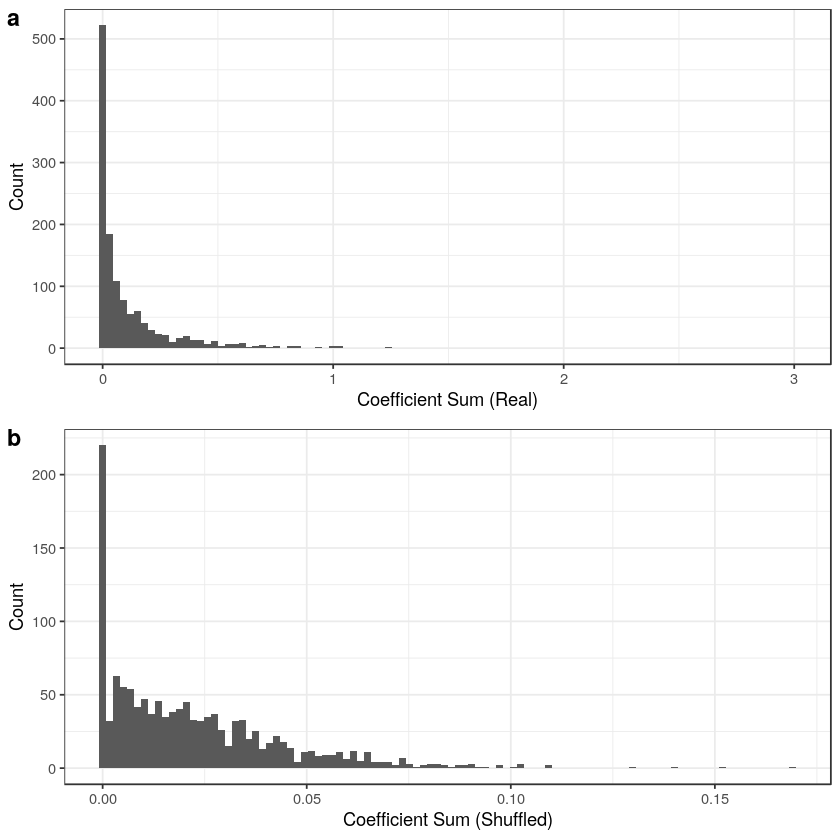

In [6]:
hist_gg <- cowplot::plot_grid(
    real_hist_gg,
    shuffled_hist_gg,
    ncol = 1,
    labels = c("a", "b")
)

hist_gg

In [7]:
coef_merge_df <- coef_df %>%
    dplyr::inner_join(coef_shuffle_df,
                      by = c("compartment", "feature_group", "measurement",
                             "channel", "parameter1", "parameter2", "feature_id"),
                      suffix = c("", "_shuffle"))

channels <- c("DNA", "AGP", "ER", "Mito", "RNA")
coef_merge_df[!coef_merge_df$channel %in% channels, "channel"] <- "NA"

head(coef_merge_df, 2)

Warning message:
“Column `feature_id` joining factors with different levels, coercing to character vector”

value_sum,compartment,feature_group,measurement,channel,parameter1,parameter2,feature_id,value_sum_shuffle
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
2.992727,Nuclei,Neighbors,FirstClosestDistance,NA,NA,NA,Nuclei_Neighbors_FirstClosestDistance_2,0.004492609
2.219923,Cells,RadialDistribution,RadialCV,ER,4of4,NA,Cells_RadialDistribution_RadialCV_ER_4of4,0.008545577


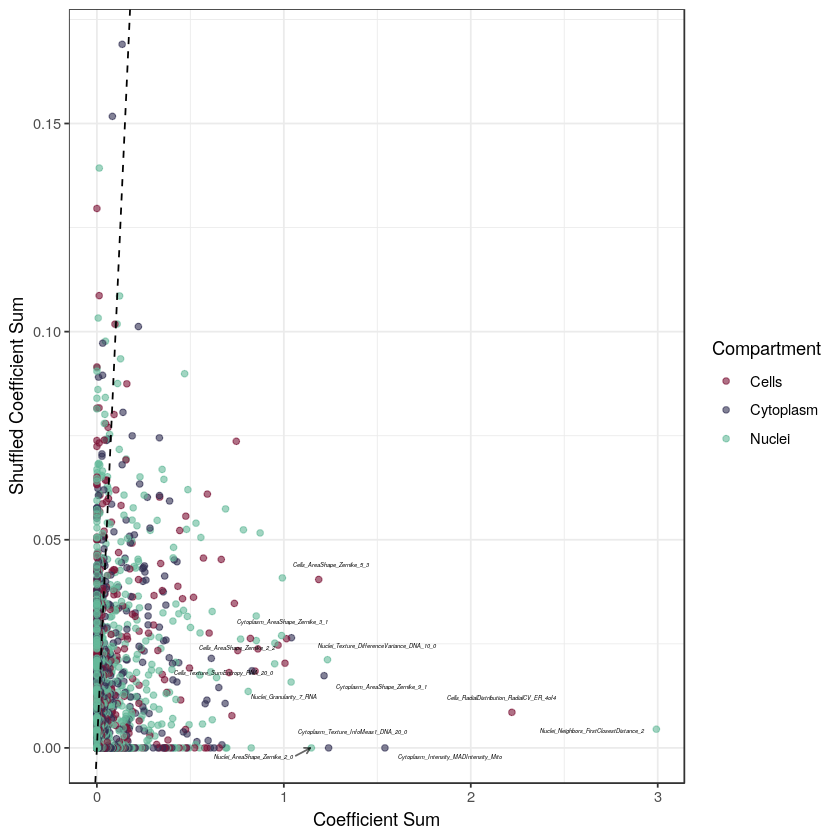

In [8]:
label_logic <- coef_merge_df$value_sum > 1

feature_distrib_gg <- ggplot(coef_merge_df,
                             aes(x = value_sum, y = value_sum_shuffle)) +
    geom_point(aes(color = compartment),
               alpha = 0.6) +
    xlab("Coefficient Sum") +
    ylab("Shuffled Coefficient Sum") +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed") +
    geom_text_repel(data = subset(coef_merge_df, label_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    box.padding = 0.4,
                    point.padding = 0.1,
                    segment.size = 0.5,
                    segment.alpha = 0.6,
                    size = 1.2,
                    fontface = "italic",
                    aes(label = feature_id,
                        x = value_sum,
                        y = value_sum_shuffle)) +
    scale_color_manual(name = "Compartment",
                         values = c("Cells" = "#7B1336",
                                    "Cytoplasm" = "#313053",
                                    "Nuclei" = "#65B999")) +

    theme_bw()

feature_distrib_gg

In [9]:
coef_channel_mean <- coef_merge_df %>%
    dplyr::group_by(channel) %>%
    dplyr::mutate(channel_mean= mean(abs(value_sum)), 
                  channel_mean_shuffle = mean(abs(value_sum_shuffle))) %>%
    dplyr::distinct(channel, channel_mean, channel_mean_shuffle) %>%
    reshape2::melt(id.vars = 'channel',
                   variable.name = "channel_type",
                   value.name = "channel_mean")

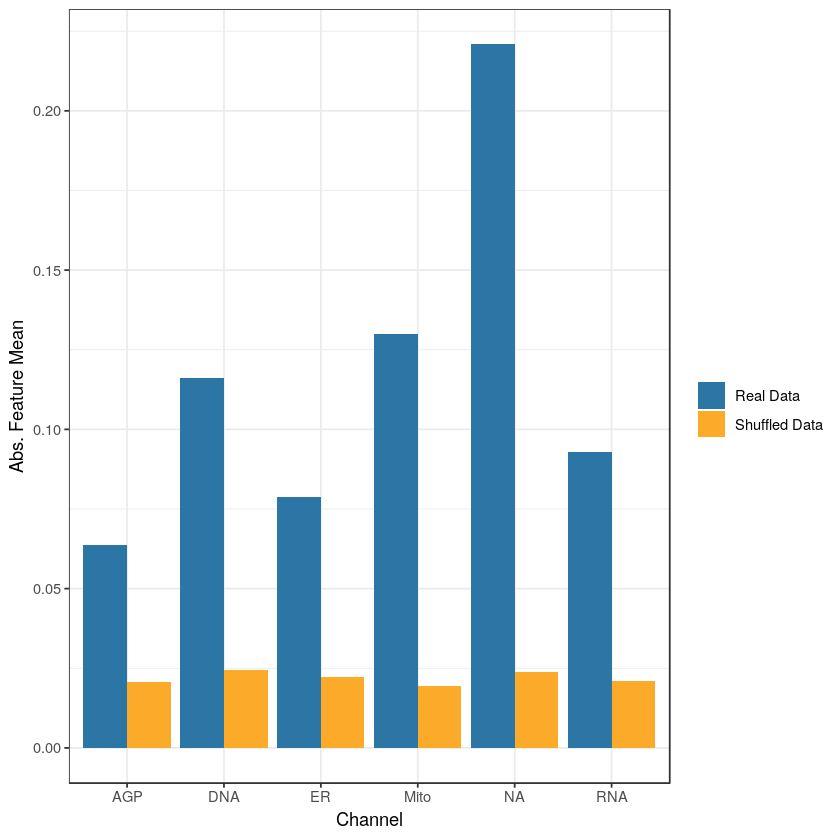

In [10]:
bar_coef_gg <- ggplot(coef_channel_mean, aes(x = channel, y = channel_mean, fill = channel_type)) +
    geom_bar(stat = "identity", position = position_dodge()) +
    xlab("Channel") +
    ylab("Abs. Feature Mean") +
    scale_fill_manual(name = "",
                      labels = c("channel_mean" = "Real Data",
                                 "channel_mean_shuffle" = "Shuffled Data"), 
                      values = c("channel_mean" = "#2B76A4",
                                 "channel_mean_shuffle" = "#FCAA2A")) +
    theme_bw()

bar_coef_gg

In [11]:
feature_type_gg <- cowplot::plot_grid(
    bar_coef_gg,
    feature_distrib_gg,
    ncol = 1,
    labels = c("c", "d")
)

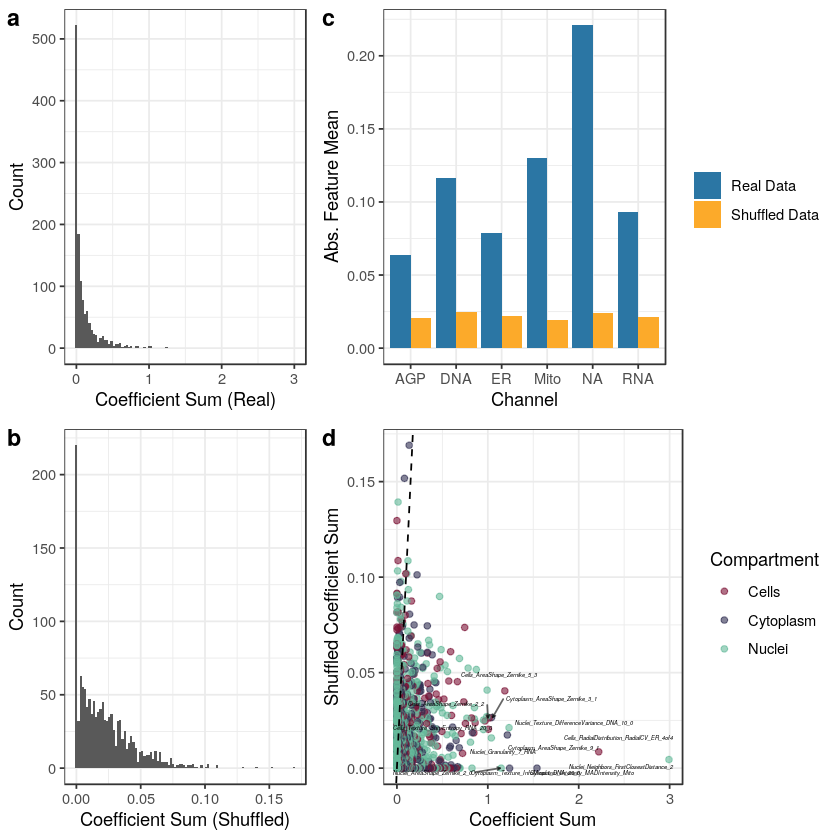

In [12]:
all_coef_gg <- cowplot::plot_grid(
    hist_gg,
    feature_type_gg,
    nrow = 1,
    rel_widths = c(0.6, 1)
)

all_coef_gg

In [13]:
cowplot_file <- file.path("figures", "model_coefficient_summary.png")

cowplot::save_plot(filename = cowplot_file,
                           plot = all_coef_gg,
                           base_height = 6,
                           base_width = 8)